해운대 해수욕장

!!! 아래 셀의 경로를 수정하여 이 노트북이 있는 디렉토리로 바꿔주세요.

In [112]:
cd /tf/mnt/research_gis/coastline-erosion-predict/samples

/tf/mnt/research_gis/coastline-erosion-predict/samples


1. 함수들 불러오기

In [113]:
import sys
sys.path.insert(0, "../lib/")
from LineProcessor import *
from Utils import convert_axis

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely


2. Shapefile 불러오기

In [114]:
TARGET_DIR = './shapefile/'
K = int(1e0)    #좌표 변화율이 너무 낮은 단위일때 곱해줄 상수

LINE_DATAS = [f'{TARGET_DIR}/관리도/WGIS_COASTLINE.shp', f'{TARGET_DIR}/현황도/WGIS_COASTLINE.shp']

#처리 가능한 geometry type : LineString, MultiLineString
#폴리곤 데이터 불러오기 불가능

geos = []
for name in LINE_DATAS:
  data = gpd.read_file(name, encoding="euc-kr")
  idx = data[(data["SD"] == "부산광역시") & (data["SGG"] == "해운대구")].index.tolist()
  for i in idx:
    target = data["geometry"][i]
    if isinstance(target, shapely.geometry.linestring.LineString):
      geos = geos + [np.array(target.coords) * K]      
    elif isinstance(target, shapely.geometry.multilinestring.MultiLineString):
      geoms_list = list(target.geoms)
      geos = geos + [np.array(geoms_list[j].coords) * K for j in range(len(geoms_list))]


3. 불러온 데이터 확인

x range : 1148687.0016381158 ~ 1155649.0293073955
y range : 1685198.3114492076 ~ 1688780.7392926717


(1685198.3114492076, 1692160.3391184872)

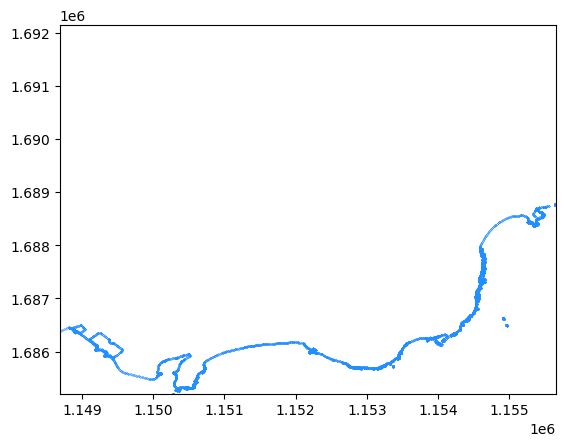

In [115]:
gca = plt.gca()
#원본 데이터가 '점'들의 좌표로 이루어 졌으므로, 보간해서 선처럼 보이게 함.
inters = interporation_points(geos, 10 * K)
#plot
gca.scatter(inters[:,0], inters[:,1], color='dodgerblue', s = 0.01)
origin_x_min = np.min(inters[:,0])
origin_x_max = np.max(inters[:,0])
origin_y_min = np.min(inters[:,1])
origin_y_max = np.max(inters[:,1])
print(f"x range : {origin_x_min} ~ {origin_x_max}")
print(f"y range : {origin_y_min} ~ {origin_y_max}")
gca.set_xlim([origin_x_min, origin_x_min + max([origin_x_max - origin_x_min, origin_y_max - origin_y_min])])
gca.set_ylim([origin_y_min, origin_y_min + max([origin_x_max - origin_x_min, origin_y_max - origin_y_min])])

4. 범위 자르기(또는 선 추가)

x range : 1150650.0 ~ 1152245.0
y range : 1685700.6617413813 ~ 1686270.0


(1685700.6617413813, 1687295.6617413813)

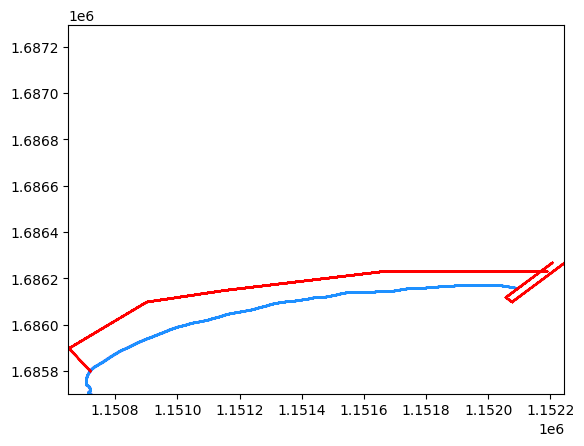

In [116]:
#자를 범위 지정
x_range = (1.1506 * 1e6 * K, 1.1521 * 1e6 * K)
y_range = (1.6857 * 1e6 * K, 1.6865 * 1e6 * K)
step = 0.1 * K

#자르고 보간해서 출력함.
cut_geo = cutting(geos, x_range, y_range)
inters = interporation_points(cut_geo, step)
gca = plt.gca()
gca.scatter(inters[:,0], inters[:,1], color='dodgerblue', s = 0.01)
#min/max 좌표 찾아둠
cut_x_min = np.min(inters[:,0])
cut_x_max = np.max(inters[:,0])
cut_y_min = np.min(inters[:,1])
cut_y_max = np.max(inters[:,1])


#선 직접 추가하기
#add_line의 원소로 np.array([(point1.x , point1.y), (point2.x, point2.y)])
#추가하면 point1 부터 point2 까지 선이 추가로 그려짐(빨간색으로 표시됨)
#
add_line = [
    np.array([
        (1.15072 * 1e6, 1.6858 * 1e6),
        (1.15065 * 1e6, 1.6859 * 1e6), 
        (1.1509 * 1e6, 1.6861 * 1e6),
        (1.15115 * 1e6, 1.68615 * 1e6),
        (1.15165 * 1e6, 1.68623 * 1e6),
        (1.15219 * 1e6, 1.68623 * 1e6),
        ]),
    np.array([
        (1.152205 * 1e6, 1.68627 * 1e6),
        (1.152055 * 1e6, 1.68612 * 1e6),
        (1.152075 * 1e6, 1.68610 * 1e6),
        (1.152245 * 1e6, 1.68627 * 1e6),
    ])
]
if len(add_line) > 0:
    add_line_inter = interporation_points(add_line, step)
    gca.scatter(add_line_inter[:,0], add_line_inter[:,1], color='red', s = 0.01)
    cut_geo += add_line
    #추가된 선들의 min/max 좌표 찾기
    add_line_x_min = np.min(add_line_inter[:,0])
    add_line_x_max = np.max(add_line_inter[:,0])
    add_line_y_min = np.min(add_line_inter[:,1])
    add_line_y_max = np.max(add_line_inter[:,1])
    #추가된 선들과 기존 선들의 min/max 찾기
    cut_x_min = np.min([cut_x_min, add_line_x_min])
    cut_x_max = np.max([cut_x_max, add_line_x_max])
    cut_y_min = np.min([cut_y_min, add_line_y_min])
    cut_y_max = np.max([cut_y_max, add_line_y_max])

#출력 범위 설정
print(f"x range : {cut_x_min} ~ {cut_x_max}")
print(f"y range : {cut_y_min} ~ {cut_y_max}")

gca.set_xlim([cut_x_min, cut_x_min + max([cut_x_max - cut_x_min, cut_y_max - cut_y_min])])
gca.set_ylim([cut_y_min, cut_y_min + max([cut_x_max - cut_x_min, cut_y_max - cut_y_min])])

5. 지도 행렬로 변환하기

concat_line : input line 6개
concat_line : line 3개가 max_diff보다 멀리 떨어져 있어 연결되지 않음.
to_grid() : a.shape : (54429, 2) / x_range : (1150650, 1152246) / y_range : (1685700, 1686271)
to_grid() : matrix shape : (1596, 571)
영역 갯수 : 5


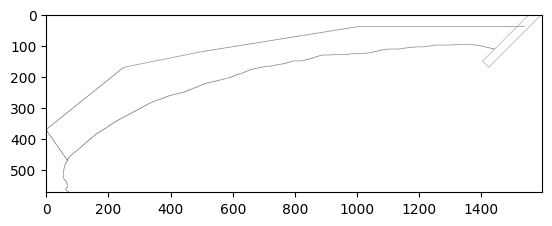

In [117]:
# shapefile의 line들을 병합해야 하는데, 병합이 가능한 최대 거리
max_diff = 30 * K

#선 병합
concat_geos = concat_line(cut_geo, max_diff)

#보간
interp_geos = interporation_points(concat_geos, step)

#행렬화
matrix, xr, yr = to_grid(interp_geos)

#행렬의 x,y축 기준을 matrix_initializer에서 요구하는 것에 맞게 치환함.
#아래는 covert_axis 함수의 설명
"""
(x,y), x축이 커지는 방향 : 오른쪽 / y축이 커지는 방향 : 위쪽
인 행렬을
(y,x), x축이 커지는 방향 : 오른쪽 / y축이 커지는 방향 : 아래쪽(일반적인 2차원 행렬/이미지 형태)
로 바꿈
"""
#
matrix = convert_axis(matrix)

#선 기반으로 영역 구분
painted_mat, colors = painting(matrix)
print(f"영역 갯수 : {colors}")

plt.imshow(img_matrix_lines(painted_mat))

6. 행렬 영역에 값 지정해주기, 확장...

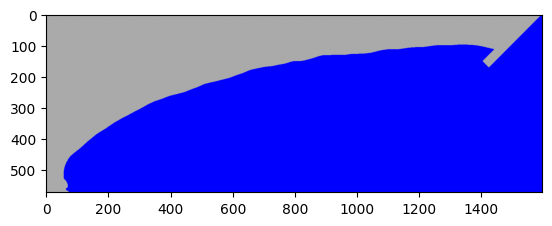

In [118]:
#결과 행렬 생성(기본값 : 벽)
x = np.ones_like(painted_mat) * 2


#바다 영역 추출 및 적용
x[painted_mat == painted_mat[-1,-1]] = 1

plt.imshow(img_matrix_areas(x))

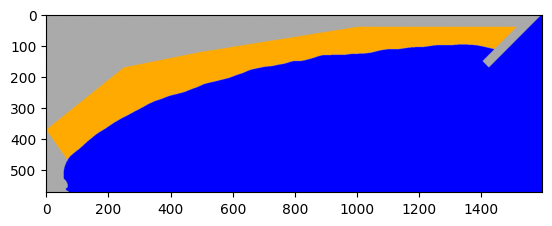

In [119]:
#모래사장 영역 추출
x[painted_mat == painted_mat[300, 200]] = 0


plt.imshow(img_matrix_areas(x))

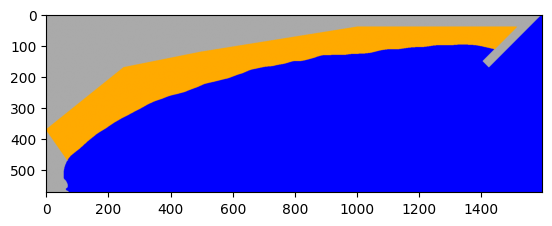

In [120]:
#모래 영역과 인접한 (3x3 범위) 곳을 모래로 바꿈
#(행렬 기본값으로 벽을 사용해서, 해안선 영역이 벽으로 채워져있음)
sand_points = np.where(x == 0)
sand_point_cnt = len(sand_points[0])
for i in range(sand_point_cnt):
    r = sand_points[0][i]
    c = sand_points[1][i]
    x[max([r - 1, 0]):r+2, max([c-1, 0]):c+2] = 0

#0번 열이 모두 벽이 아니므로, 0번 열의 값은 벽으로 변경
#CA에서 범위 밖의 영역은 모두 '바다'로 처리하기 때문에, 의도하는 것이 아니라면 반드시 지상 영역의 끝 셀은 벽으로 지정해야함.
x[:,0] = 2


plt.imshow(img_matrix_areas(x))

7. 처리 완료된 행렬 저장하기

In [121]:
save_path = "./matrix_file/sea.npy"
np.save(save_path, x)
print(f"행렬 처리 결과가 {save_path}에 저장되었습니다.")

행렬 처리 결과가 ./matrix_file/sea.npy에 저장되었습니다.
